In [30]:
import csv
import os
import cv2
from PIL import Image
import matplotlib.pyplot as plt

import numpy as np


import torch

from pytorch3d.structures import Pointclouds
import pytorch3d.transforms as tforms
from pytorch3d.vis.plotly_vis import AxisArgs, plot_batch_individually, plot_scene
from pytorch3d.renderer import (
    look_at_view_transform,
    look_at_rotation,
    PerspectiveCameras, 
    PointsRasterizationSettings,
    PointsRenderer,
    PulsarPointsRenderer,
    PointsRasterizer,
    AlphaCompositor,
    NormWeightedCompositor
)

In [99]:
from mobile_sam import sam_model_registry, SamAutomaticMaskGenerator, SamPredictor

model_type = "vit_t"
sam_checkpoint = "./zero_shot_scene_segmentation/models/MobileSAM/MobileSAM/weights/mobile_sam.pt"

device = "cuda" if torch.cuda.is_available() else "cpu"

mobile_sam = sam_model_registry[model_type](checkpoint=sam_checkpoint)
mobile_sam.to(device=device)
mobile_sam.eval()

from mobile_sam import SamAutomaticMaskGenerator

mask_generator = SamAutomaticMaskGenerator(mobile_sam)


In [7]:
root = "./zero_shot_scene_segmentation/datasets/raw_data/trajectory_renders/train/00006-HkseAnWCgqk"
files = os.listdir(root)
files[:10]

['00006-HkseAnWCgqk.0000000004.0000001000.0000000204.DEPTH.png',
 '00006-HkseAnWCgqk.0000000043.0000000100.0000000099.DEPTH.png',
 '00006-HkseAnWCgqk.0000000009.0000000100.0000000021.SEM.png',
 '00006-HkseAnWCgqk.0000000031.0000000100.0000000166.RGB.0000000000.png',
 '00006-HkseAnWCgqk.0000000023.0000000100.0000000082.SEM.png',
 '00006-HkseAnWCgqk.0000000021.0000001000.0000000037.SEM.png',
 '00006-HkseAnWCgqk.0000000045.0000001000.0000000091.SEM.png',
 '00006-HkseAnWCgqk.0000000035.0000000100.0000000082.DEPTH.png',
 '00006-HkseAnWCgqk.0000000032.0000000100.0000000270.DEPTH.png',
 '00006-HkseAnWCgqk.0000000010.0000001000.0000000066.RGB.0000000000.png']

In [15]:
SCENE_DIR = root
SCENE_VIEWS_FILE = os.path.join(root, "00006-HkseAnWCgqk.render_view_poses.csv")
extracting_sequence = None
sequence_data = None

with open(SCENE_VIEWS_FILE, 'r') as csvfile:
    pose_reader = csv.reader(csvfile, delimiter=',')

    for pose_idx, pose_meta in enumerate(pose_reader):
        info_ID = pose_meta[:4]
        info_position = pose_meta[4:7]
        info_rotation = pose_meta[7:11]

        # Skip information line if it is first
        if info_ID[0]=='Scene-ID':
            continue

        scene_id, trajectory_id, sensor_height_id, view_id = info_ID
        x_pos, y_pos, z_pos = info_position
        quat_w, quat_x, quat_y, quat_z = info_rotation

        # Parse pose infomration out of string type
        x_pos, y_pos, z_pos = float(x_pos), float(y_pos), float(z_pos)
        quat_w, quat_x, quat_y, quat_z = float(quat_w), float(quat_x), float(quat_y), float(quat_z)


        if (scene_id, trajectory_id, sensor_height_id) != extracting_sequence:
            if sequence_data is not None:
                break
            extracting_sequence = (scene_id, trajectory_id, sensor_height_id)
            sequence_data = []

            
        rgb_file = f"{'.'.join(info_ID)}.RGB.{0:010}.png"
        depth_file = f"{'.'.join(info_ID)}.DEPTH.png"
        sem_file = f"{'.'.join(info_ID)}.SEM.png"
        
        sequence_data.append({"position":(x_pos, y_pos, z_pos),
                          "rotation":(quat_w, quat_x, quat_y, quat_z),
                          "rgb": os.path.join(SCENE_DIR, rgb_file),
                          "depth": os.path.join(SCENE_DIR, depth_file),
                          "semantic": os.path.join(SCENE_DIR, sem_file)})

In [20]:
def inverse_projection(K, depth_map):
    assert K.shape==(3,3)
    assert depth_map.ndim==3 and depth_map.shape[2]==1
    
    height, width, _ = depth_map.shape
    grid_h, grid_w = torch.meshgrid(torch.arange(height), torch.arange(width), indexing='ij')
    
    pixel_coordinates_homogeneous_map = torch.stack((grid_w, grid_h, torch.ones_like(grid_h)), dim=-1)
    point_projections_nonhomogeneous_map = pixel_coordinates_homogeneous_map * depth_map
    point_projections_nonhomogeneous = point_projections_nonhomogeneous_map.reshape(-1, 3)
    
    points_camera_frame_nonhomogeneous = torch.matmul(point_projections_nonhomogeneous, torch.inverse(K).T)
    points_camera_frame_nonhomogeneous_map = points_camera_frame_nonhomogeneous.reshape(height, width, 3)
    
    return points_camera_frame_nonhomogeneous_map

def transform_points(RT, points_world_frame_nonhomogeneous_map):
    assert RT.shape==(3,4)
    
    height, width, _ = points_world_frame_nonhomogeneous_map.shape
    points_world_frame_homogeneous_map = torch.cat((points_world_frame_nonhomogeneous_map, torch.ones(height,width,1)), dim=2)
    points_camera_frame_nonhomogeneous = torch.matmul(points_world_frame_homogeneous_map.reshape(-1,4), RT.T)
    points_camera_frame_nonhomogeneous_map = points_camera_frame_nonhomogeneous.reshape(height, width, 3)
    return points_camera_frame_nonhomogeneous_map

def projection(K, points_camera_frame_nonhomogeneous_map):
    assert K.shape==(3,3)
    
    height, width, _ = points_camera_frame_nonhomogeneous_map.shape
    points_camera_frame_nonhomogeneous = points_camera_frame_nonhomogeneous_map.reshape(-1,3)
    point_projections_nonhomogeneous = torch.matmul(points_camera_frame_nonhomogeneous, K.T)
    point_projections_nonhomogeneous_map = point_projections_nonhomogeneous.reshape(height, width, 3)
    pixel_coordinates_map = point_projections_nonhomogeneous_map / point_projections_nonhomogeneous_map[:,:,2].reshape(height, width, 1)
    
    pixel_coordinates_map = pixel_coordinates_map[:,:,:2]
    
    return pixel_coordinates_map

In [116]:
import time

In [21]:
K = torch.tensor([[465.6029, 0.0,      320.00],
                      [0.0,      465.6029, 240.00],
                      [0.0,      0.0,      1.0]])

Sam Processed in: 2.841535806655884 seconds


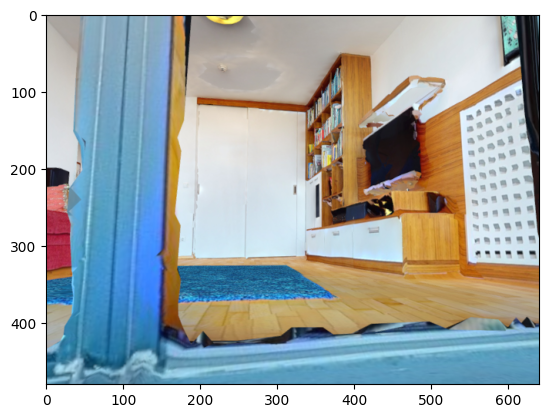

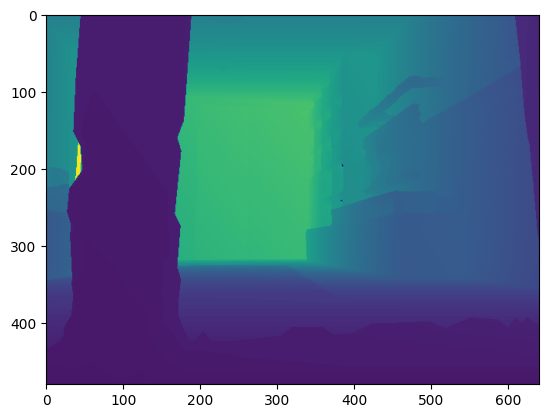

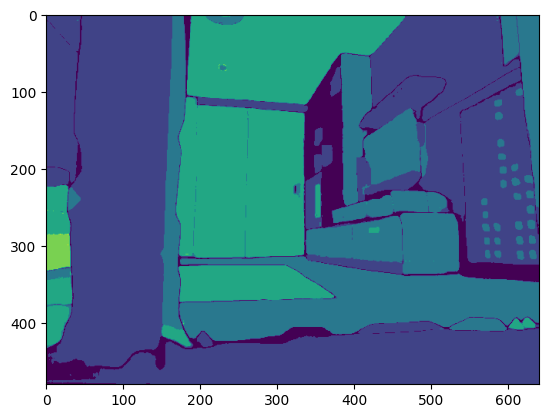

In [135]:
index = 0



rgb_path = sequence_data[index]["rgb"]
dep_path = sequence_data[index]["depth"]
sem_path = sequence_data[index]["semantic"]

starting_position = sequence_data[index]["position"]
starting_rotation = sequence_data[index]["rotation"]

dep_image = cv2.imread(dep_path, cv2.IMREAD_UNCHANGED)
rgb_image = Image.open(rgb_path).convert('RGB')
sem_image = Image.open(sem_path).convert('RGB')


dep_tensor = torch.tensor(dep_image.astype(np.float32)/1000.0)
rgb_tensor = torch.tensor(np.array(rgb_image).astype(np.float32)/255.0)

sam_time = time.time()
masks = mask_generator.generate(np.array(rgb_image))
mask_features = torch.cat([torch.tensor(anno['segmentation']).unsqueeze(2) for anno in masks], axis=2)
print("Sam Processed in:",time.time()-sam_time,"seconds")

plt.imshow(rgb_tensor)
plt.show()
plt.imshow(dep_tensor)
plt.show()
plt.imshow(torch.sum(mask_features,axis=2))
plt.show()

In [71]:
import math
RC=torch.tensor([[math.cos(math.pi), -math.sin(math.pi),0],
             [math.sin(math.pi), math.cos(math.pi), 0],
             [0,0,1]]).unsqueeze(0)

# cameras = PerspectiveCameras(device='cpu', R=RT[:,:3].unsqueeze(0), T=RT[:,3].unsqueeze(0), znear=[0.01], fov=[69], aspect_ratio=[640/480.0], degrees=True)
cameras = PerspectiveCameras(R=RC, focal_length=((465.6029,465.6029),), image_size=((480,640),),principal_point=((320,240),), in_ndc=False, device='cuda')


# Define the settings for rasterization and shading. Here we set the output image to be of size
# 512x512. As we are rendering images for visualization purposes only we will set faces_per_pixel=1
# and blur_radius=0.0. Refer to raster_points.py for explanations of these parameters. 
raster_settings = PointsRasterizationSettings(
    image_size=(480,640), 
    radius = 0.007,
    points_per_pixel = 10
)


# Create a points renderer by compositing points using an alpha compositor (nearer points
# are weighted more heavily). See [1] for an explanation.
rasterizer = PointsRasterizer(cameras=cameras, raster_settings=raster_settings)
renderer = PointsRenderer(
    rasterizer=rasterizer,
    compositor=AlphaCompositor()
)

Render time: 0.0895223617553711 seconds


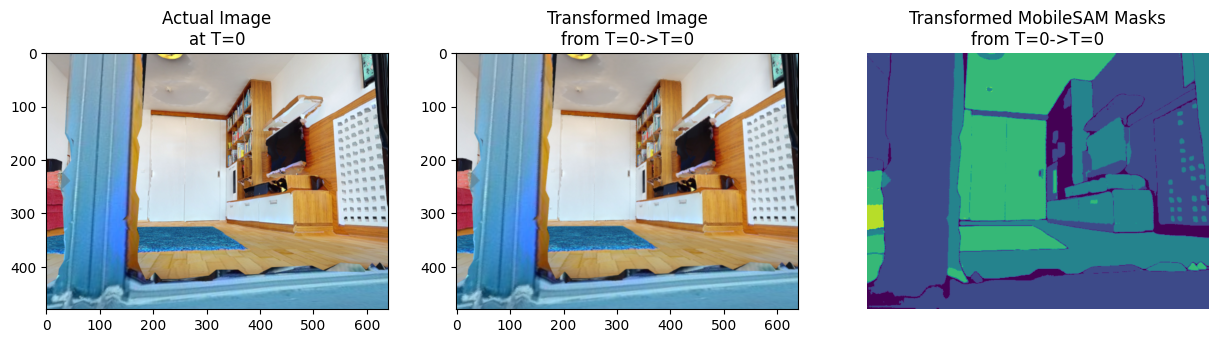

Render time: 0.09908390045166016 seconds


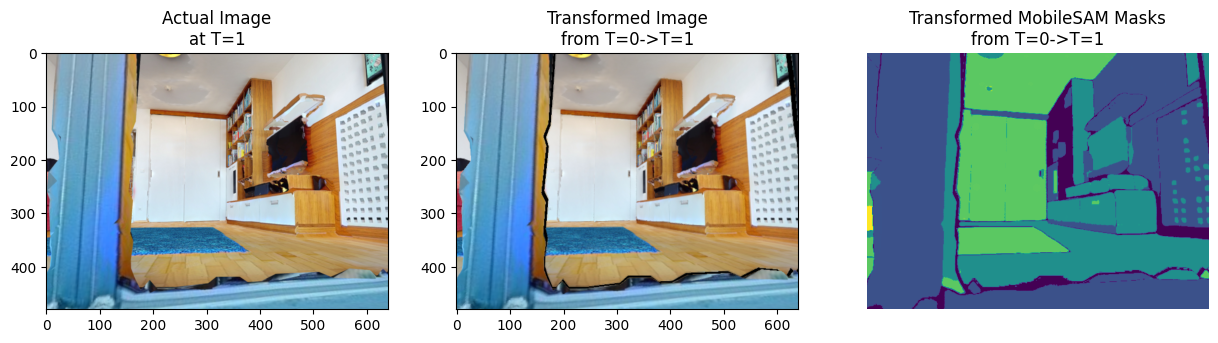

Render time: 0.08226966857910156 seconds


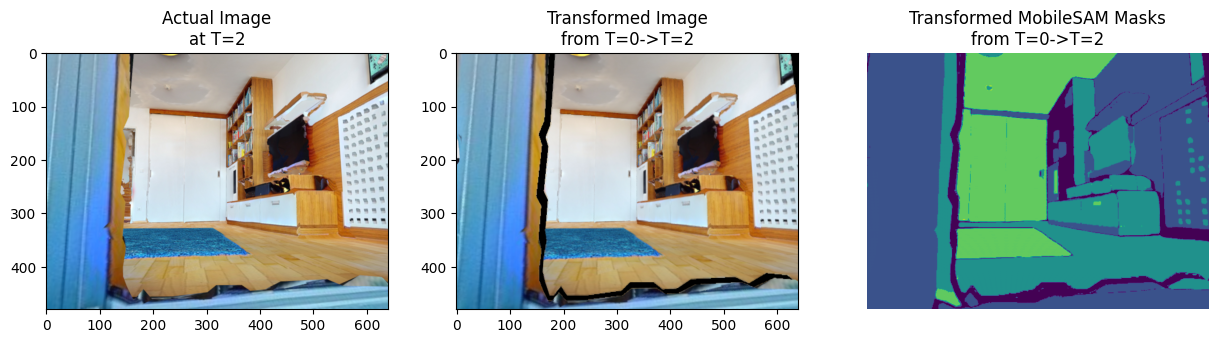

Render time: 0.0682210922241211 seconds


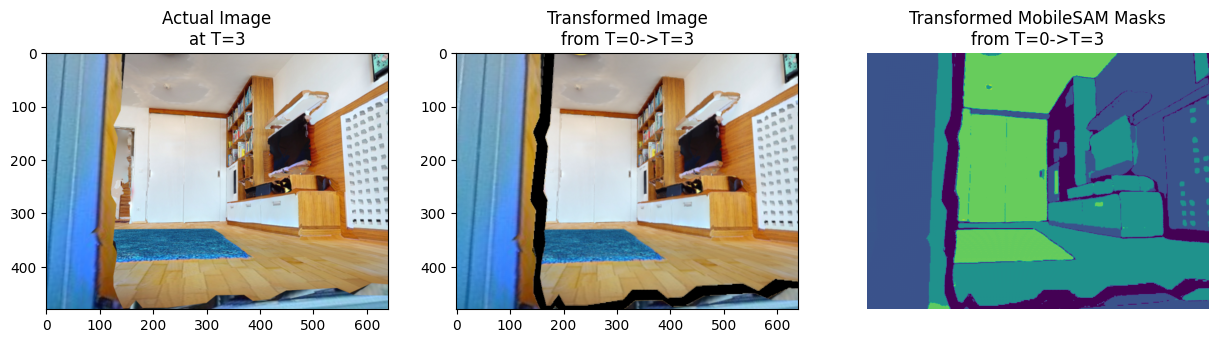

Render time: 0.06956052780151367 seconds


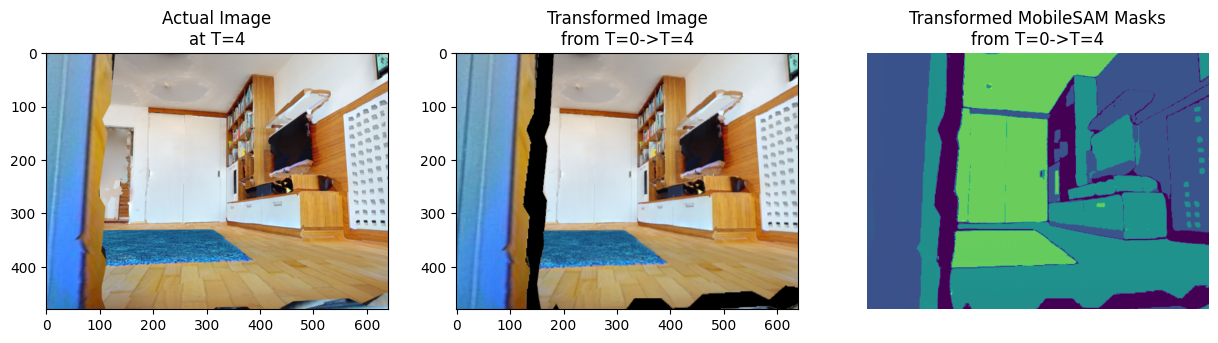

Render time: 0.07310271263122559 seconds


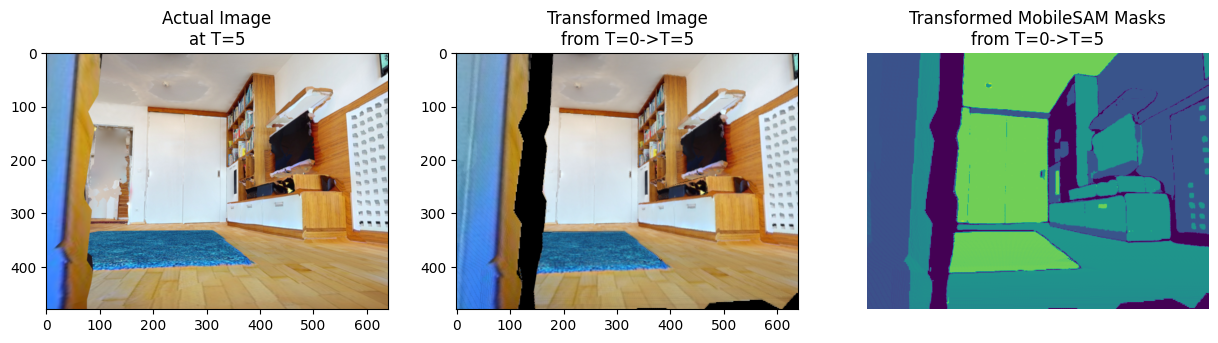

Render time: 0.06691908836364746 seconds


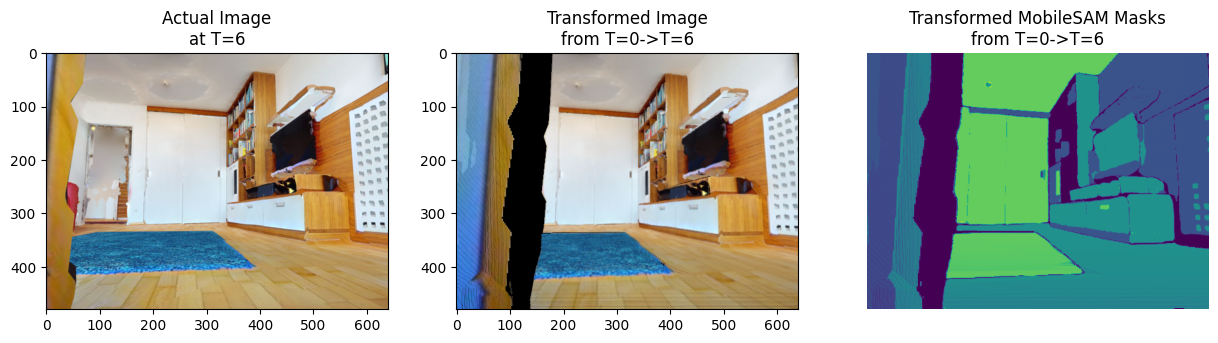

Render time: 0.0674276351928711 seconds


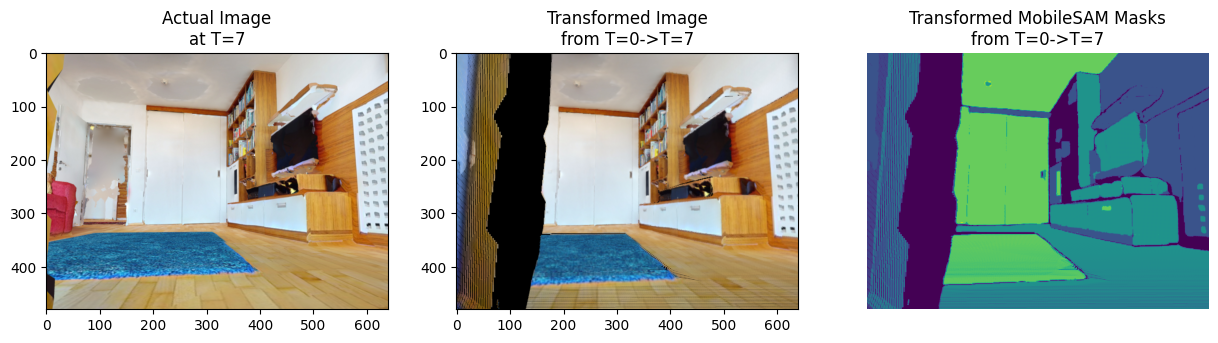

Render time: 0.07452034950256348 seconds


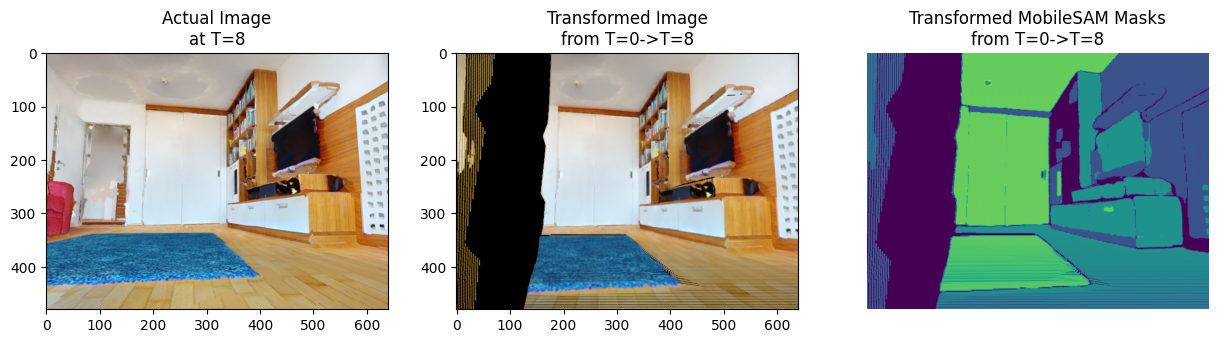

Render time: 0.06493830680847168 seconds


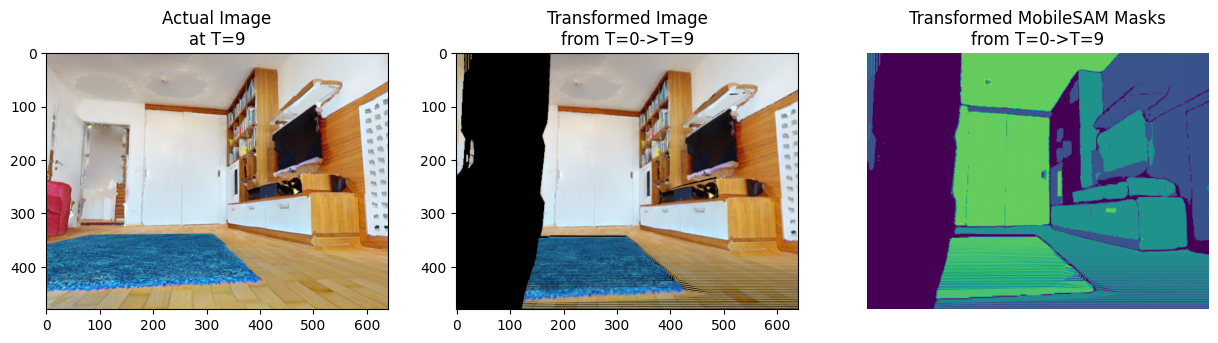

Render time: 0.06492853164672852 seconds


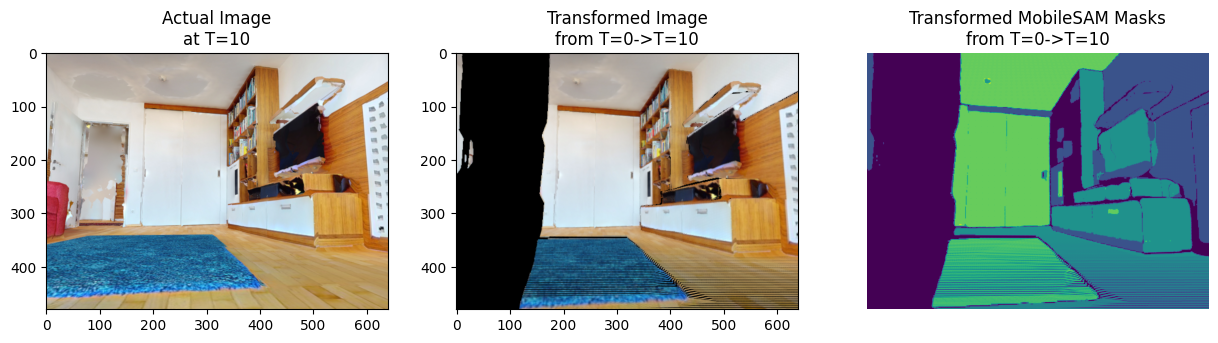

Render time: 0.06543445587158203 seconds


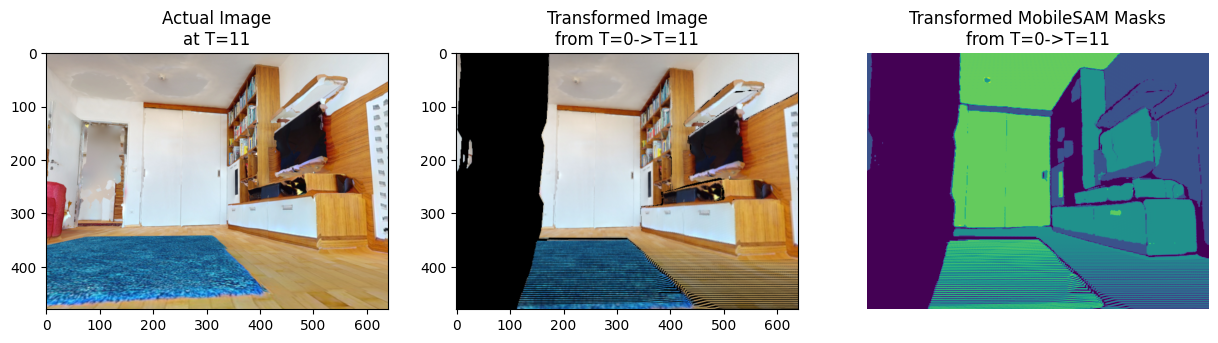

Render time: 0.06489753723144531 seconds


KeyboardInterrupt: 

In [138]:
for i in range(50):
    
    
    translate_start_to_i = -(torch.tensor(sequence_data[i]["position"])-torch.tensor(starting_position))
    rotate_start_to_i = tforms.quaternion_multiply(torch.tensor(sequence_data[i]["rotation"]), tforms.quaternion_invert(torch.tensor(starting_rotation)))
    rotate_start_to_i = tforms.quaternion_to_matrix(rotate_start_to_i)
    translate_start_to_i = torch.tensor([translate_start_to_i[1], translate_start_to_i[2], translate_start_to_i[0]])
    rotate_start_to_i = torch.eye(3)
    RT = torch.cat((rotate_start_to_i,translate_start_to_i.reshape(3,1)), dim=-1)
#     start_rot = torch.tensor(starting_rotation)
#     start_pos = torch.tensor(starting_position).reshape(3,1)
    
#     CamA2World = torch.cat((tforms.quaternion_to_matrix(start_rot), start_pos), dim=-1)
    
#     CamB_rot = torch.tensor(sequence_data[i]["rotation"])
#     CamB_pos = torch.tensor(sequence_data[i]["position"])
#     World2CamB = torch.cat((tforms.quaternion_to_matrix(start_rot), start_pos), dim=-1)
#     print(RT)
#     RT = torch.cat((tforms.quaternion_to_matrix(tforms.quaternion_invert()), -CamB_pos), dim=-1)
#     RT_ = torch.cat((tforms.quaternion_to_matrix(tforms.quaternion_invert(torch.tensor(sequence_data[i]["rotation"]))), -torch.tensor(sequence_data[i]["position"]).reshape(3,1)), dim=-1)
#     print(torch.matmul(RT.T, RT_))

    points_camera_frame_nonhomogeneous_map = inverse_projection(K, dep_tensor.unsqueeze(2))
    points_camera_frame_nonhomogeneous_map_ = transform_points(RT,points_camera_frame_nonhomogeneous_map)
#     points_camera_frame_nonhomogeneous_map_ = transform_points(RT_,points_camera_frame_nonhomogeneous_map_)
    
    
    points= points_camera_frame_nonhomogeneous_map_.reshape(-1,3)#*torch.tensor([[-1,-1,1]])
    #print(points.shape, rgb_tensor.shape)
    point_cloud = Pointclouds(points=[points], features=[torch.cat((rgb_tensor.reshape(-1,3),mask_features.reshape(-1,mask_features.shape[2])),axis=1)])
    point_cloud = point_cloud.cuda()
    
    
    actual_rgb_path = sequence_data[i]["rgb"]
    actual_rgb_image = Image.open(actual_rgb_path).convert('RGB')
    
    render_time = time.time()
    images = renderer(point_cloud)
    print("Render time:",time.time()-render_time,"seconds")
    #print(images.shape)
    fig, axarr = plt.subplots(1,3, figsize=(15,8))
    axarr[0].set_title("Actual Image\nat T="+str(i))
    axarr[0].imshow(actual_rgb_image)
    axarr[1].set_title("Transformed Image\nfrom T=0->T="+str(i))
    axarr[1].imshow(images[0, ..., :3].cpu().numpy())
    axarr[2].set_title("Transformed MobileSAM Masks\nfrom T=0->T="+str(i))
    axarr[2].imshow(torch.sum(images[0, ..., 3:],axis=-1).cpu().numpy())
    #axarr[3].imshow(np.sum((images[0, ..., :3].cpu().numpy()-np.array(actual_rgb_image)/255.0)**2,axis=-1))
    plt.axis("off");
    plt.show()